# Introduction to Topic Modeling

### What is Topic Modeling?

In Natural Language Processing (NLP), **topic modeling** is an unsupervised text mining technique that analyzes large collections of documents to uncover latent thematic structures. Topic models identify recurring terms or expressions across a corpus and group them into abstract topics, each represented by a set of statistically significant keywords. These automatically inferred topics can then be used to characterize or annotate documents, supporting downstream tasks such as thematic clustering or document classification.

### How Topic Modeling Works

Topic modeling is an unsupervised learning technique that does not rely on labeled training data. It identifies latent thematic structures within large collections of documents by analyzing patterns of word co-occurrence. These patterns are formalized as topics, which are probabilistic distributions over a fixed vocabulary and serve to characterize the semantic content of each document.

The process typically begins with a document-term matrix, where rows represent documents and columns represent terms. Each cell indicates the frequency of a term within a document. This matrix defines a high-dimensional vector space in which documents are positioned based on lexical composition. Documents with similar term usage tend to cluster together, suggesting shared thematic content.

Although topic modeling often assumes a bag-of-words representation, it goes beyond simple frequency analysis. It infers latent topics by grouping frequently co-occurring terms into coherent sets. Each document is then represented as a mixture of these topics. This approach approximates the generative processes that underlie the production of the corpus and provides a structured representation of its discourse.

# Latent Dirichlet Allocation

**Latent Dirichlet Allocation** (LDA) is a hierarchical Bayesian model that represents documents as mixtures of latent topics, where each topic is a distribution over words. The generative process assumes that for each document, a topic distribution is sampled from a Dirichlet prior, and for each word position, a topic assignment is drawn from this distribution, followed by a word drawn from the corresponding topic-specific word distribution.

Formally, for each document $d \in \{1, \dots, M\}$, the generative process is:

1. Sample topic proportions $\theta_d \sim \text{Dir}(\alpha)$  
2. For each word position $n \in \{1, \dots, N_d\}$:  
   - Sample topic assignment $z_{d,n} \sim \text{Multinomial}(\theta_d)$  
   - Sample word $w_{d,n} \sim \text{Multinomial}(\phi_{z_{d,n}})$, where $\phi_k \sim \text{Dir}(\beta)$

Here:
- $\alpha \in \mathbb{R}^K$ is the Dirichlet prior over document-topic distributions  
- $\beta \in \mathbb{R}^{K \times V}$ parametrizes the topic-word distributions  
- $K$ is the number of latent topics  
- $V$ is the vocabulary size

Inference seeks to estimate the posterior distribution over the latent variables $\theta$, $z$, and $\phi$ given the observed words $w$. Since direct computation of the posterior is intractable, a variational Bayesian approach is employed. This method introduces a tractable variational distribution $q(\theta, z \mid \gamma, \phi)$ that factorizes as:

$$
q(\theta, z \mid \gamma, \phi) = q(\theta \mid \gamma) \prod_{n=1}^{N_d} q(z_n \mid \phi_n)
$$

where $\gamma \in \mathbb{R}^K$ is the variational parameter for the Dirichlet distribution over topics, and each $\phi_n \in \mathbb{R}^K$ is a variational multinomial parameter over topic assignments for word position $n$.

The inference procedure maximizes a lower bound on the marginal log-likelihood of the data:

$$
\ell(\alpha, \beta) = \sum_{d=1}^{M} \log p(w_d \mid \alpha, \beta)
$$

This is achieved through an iterative **variational Expectation-Maximization (EM)** algorithm:

- **E-step**: For each document, update the variational parameters $\gamma$ and $\phi$ to minimize the Kullback–Leibler divergence between the variational distribution and the true posterior.
- **M-step**: Update the model parameters $\alpha$ and $\beta$ to maximize the expected log-likelihood under the current variational parameters.

The variational updates are given by:

$$
\phi_{n,i} \propto \beta_{i,w_n} \exp\left[\Psi(\gamma_i) - \Psi\left(\sum_{j=1}^{K} \gamma_j\right)\right]
$$

$$
\gamma_i = \alpha_i + \sum_{n=1}^{N_d} \phi_{n,i}
$$

where $\Psi$ denotes the digamma function. These updates are applied iteratively until convergence, yielding approximate posterior estimates for the latent topic structure.

### Dataset

The dataset consists of titles and abstracts from scientific research papers, forming a corpus characterized by dense terminology and layered conceptual content. Many documents reflect multiple research directions, and thematic attribution is not confined to a single interpretive axis.

This is confirmed by a frequency-based visualization that encodes the presence of latent dimensions as binary vectors and aggregates the count of unique intersection patterns. The resulting distribution shows that several documents are simultaneously associated with multiple semantic groupings, indicating that exclusivity is not preserved across the corpus.

In addition, the relative prevalence of these thematic regions is uneven. Some are broadly represented and recur across a wide range of documents, while others appear sporadically and are limited to a narrow subset. This imbalance reflects an asymmetrical distribution of conceptual coverage, where dominant areas coexist with less represented ones. Such behavior invites careful consideration when assessing thematic relevance and corpus structure.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from upsetplot import UpSet, from_indicators
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
from wordcloud import WordCloud

In [2]:
data = pd.read_csv("../data/raw/train.csv")

In [3]:
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
data.tail()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0
20971,20972,Why optional stopping is a problem for Bayesians,"Recently, optional stopping has been a subje...",0,0,1,1,0,0


In [5]:
data = data.drop(columns=['ID'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TITLE                 20972 non-null  object
 1   ABSTRACT              20972 non-null  object
 2   Computer Science      20972 non-null  int64 
 3   Physics               20972 non-null  int64 
 4   Mathematics           20972 non-null  int64 
 5   Statistics            20972 non-null  int64 
 6   Quantitative Biology  20972 non-null  int64 
 7   Quantitative Finance  20972 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ MB


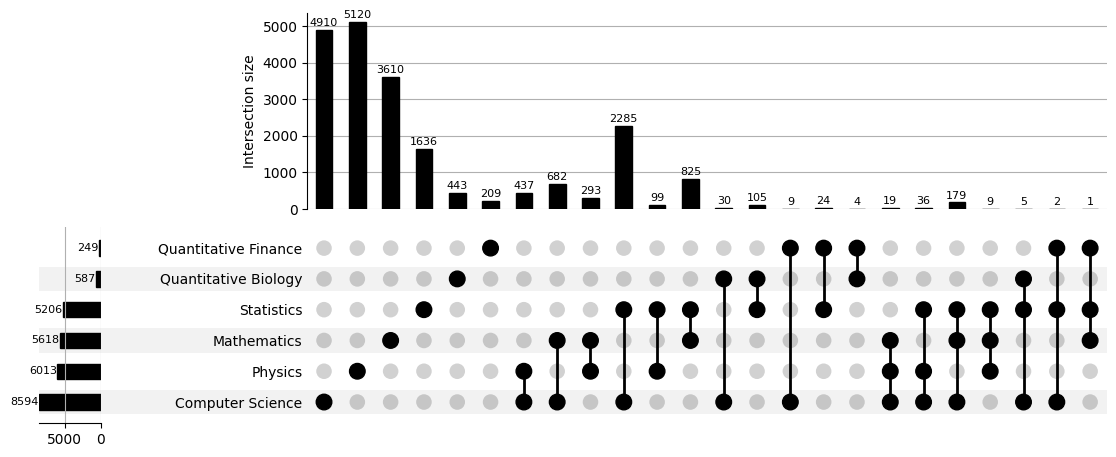

In [7]:
dfwithbool = data.select_dtypes(include=["int", "bool"]).astype(bool)
upset_data = from_indicators(dfwithbool.columns, data=dfwithbool)

up = UpSet(upset_data, show_counts=True, facecolor="black")
up.plot()

for text in plt.gcf().findobj(match=plt.Text):
    if text.get_text().isdigit():   
        text.set_fontsize(8)        
        text.set_color("black")      

plt.show()

### Preprocessing the Data

The corpus undergoes a structured preprocessing pipeline to enhance lexical consistency and reduce noise prior to topic modeling. Each document is transformed into a normalized sequence of tokens through the following operations:

- **Stopword removal**: Common functional words with low semantic content are excluded to prevent dilution of thematic signals.
- **Lemmatization**: Tokens are reduced to their canonical forms to consolidate morphological variants and improve alignment across documents.
- **Token normalization**: Non-alphabetic characters are removed, and short fragments are filtered out to retain only lexically relevant units.

Following preprocessing, a term-to-index mapping is constructed to define the vocabulary space. This dictionary enables the construction of a bag-of-words representation, where each document is encoded as a sparse vector of token frequencies. The bag-of-words model is essential in topic modeling, as it abstracts away syntactic structure and captures latent semantic patterns through co-occurrence statistics.

To ensure that the vocabulary reflects meaningful and generalizable content, the dictionary is filtered. Terms that appear in very few documents are excluded to eliminate idiosyncratic noise, while those occurring too frequently are removed to suppress overly generic content. This dual filtering mechanism retains tokens that are both discriminative and sufficiently distributed, improving the stability and interpretability of downstream topic inference.


In [8]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def pre_process(text: str) -> list[str]:
    tokens = simple_preprocess(text, deacc=True, min_len=3)
    return [
        lemmatizer.lemmatize(re.sub(r"[^A-Za-z]+", " ", token))
        for token in tokens
        if token not in stop_words
    ]

data["texts"] = data["ABSTRACT"].apply(pre_process)

In [9]:
NO_BELOW = 150
NO_ABOVE = 0.1

dictionary = corpora.Dictionary(data["texts"])
dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
print(f"Dictionary size: {len(dictionary):,} tokens.")

Dictionary size: 1,709 tokens.


### Inferring Latent Topics

Variational Bayesian inference is employed over multiple passes to refine the allocation of terms across latent semantic dimensions. Hyperparameters governing the document-level and topic-level priors are set adaptively, allowing the algorithm to calibrate its assumptions in response to corpus-specific distributions.

To assess the semantic consistency of the inferred structures, an external metric is computed using the **Contextual Vector Coherence Score**, defined as:

$$
\text{C}_V = \frac{1}{|W|(|W|-1)} \sum_{i \neq j} \text{NPMI}(w_i, w_j) \cdot \text{cosine}(w_i, w_j)
$$

where $W$ is the set of top words in a topic, and NPMI denotes the normalized pointwise mutual information between word pairs, computed over a sliding window in the original texts. The cosine term reflects the semantic similarity of word vectors in a context-sensitive space. A higher score indicates that the most representative terms of a given structure tend to co-occur in similar contexts across the corpus, reinforcing the interpretability and internal alignment of the grouping. While not absolute, this metric offers a comparative basis for assessing the plausibility of the inferred partitions.

To support qualitative inspection, each topic is visualized as a word cloud, where term prominence is proportional to its weight within the topic distribution. This graphical representation facilitates intuitive assessment of dominant terms and thematic focus, offering a complementary perspective to numerical metrics. Word clouds are especially useful for identifying lexical anchors and semantic drift across topics.

In [10]:
corpus = [dictionary.doc2bow(text) for text in data["texts"]]

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=6,         
                     passes=20,
                     random_state=42,
                     alpha='auto',
                     eta='auto')

coherence_model = CoherenceModel(model=lda_model,
                                  texts=data["texts"],
                                  dictionary=dictionary,
                                  coherence='c_v')

coherence_score = coherence_model.get_coherence()
print(f"C_V Coherence Score: {coherence_score:.4f}")

C_V Coherence Score: 0.6256


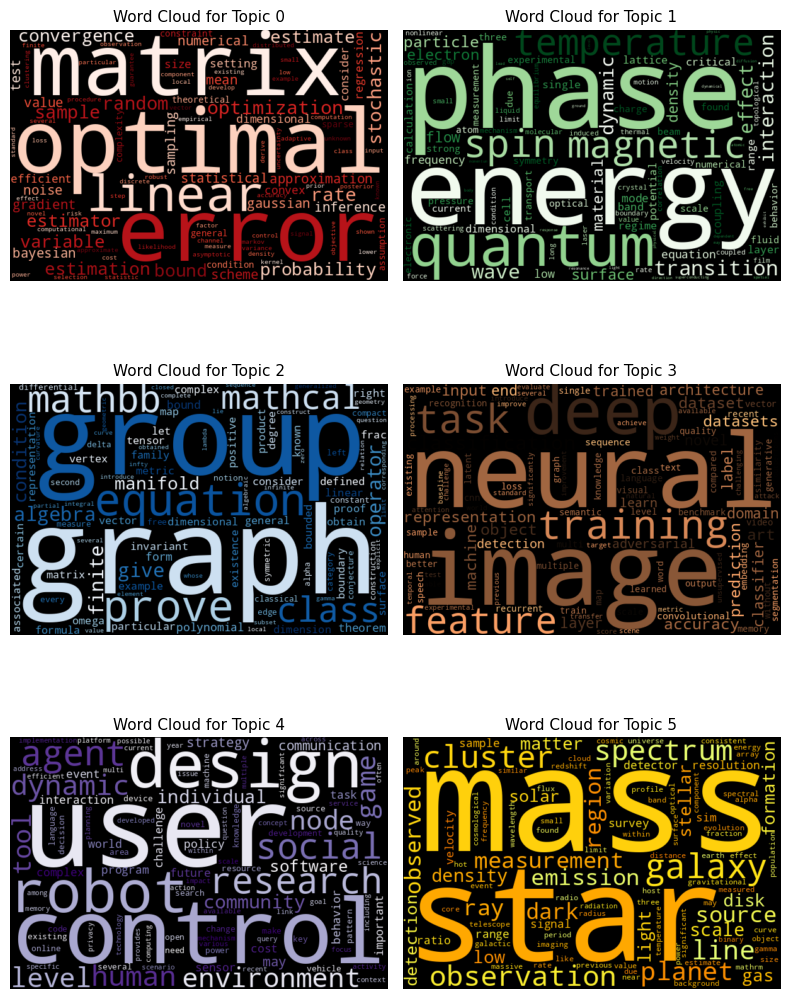

In [11]:
topics = lda_model.show_topics(num_topics=6, num_words=100, formatted=False)
top_colors = ['Reds', 'Greens', 'Blues', 'copper', 'Purples', 'Wistia']

fig, axes = plt.subplots(3, 2, figsize=(8,12))

for i, (topic_id, terms) in enumerate(topics):

    term_weights = {word: weight for word, weight in terms}

    wc = WordCloud(width=600, height=400,
                   background_color='black',
                   colormap=top_colors[i % len(top_colors)],
                   max_words=100).generate_from_frequencies(term_weights)
    
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Word Cloud for Topic {topic_id}", fontsize=11, color='black')
    ax.axis('off')
    ax.set_facecolor('black')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Drawing on the lexical composition revealed by the word clouds, it becomes possible to assign descriptive labels to each latent structure with a high degree of semantic confidence. The alignment between these emergent groupings and the original thematic categories in the dataset is sufficiently robust to justify retaining the predefined labels and establishing a formal mapping between annotated classes and inferred topics.

Each document is associated with a probability vector that quantifies its degree of affiliation across the latent semantic dimensions. Such representation allows for refined thematic profiling, where individual texts may exhibit partial alignment with multiple conceptual regions. Although the distribution originates from a generative modeling procedure, the resulting structure remains suitable for various downstream analytical applications.

In [12]:
topic_map = {
    0: "Statistics",
    1: "Physics",
    2: "Mathematics",
    3: "Computer Science",
    4: "Quantitative Finance",
    5: "Quantitative Biology"
}

df_topics = pd.DataFrame([
    dict(lda_model.get_document_topics(doc, minimum_probability=0.0))
    for doc in corpus
]).rename(columns=topic_map)

df_topics = df_topics[[
    "Computer Science", "Physics", "Mathematics",
    "Statistics", "Quantitative Biology", "Quantitative Finance"
]]

df_topics = pd.concat([data[["TITLE", "ABSTRACT"]], df_topics], axis=1)

In [13]:
df_topics.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,0.570456,0.058932,0.001035,0.291517,0.000454,0.077607
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,0.783286,0.002991,0.003764,0.004047,0.201644,0.004268
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0.002862,0.003328,0.856561,0.130671,0.001836,0.004742
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0.002138,0.128503,0.366428,0.498013,0.001372,0.003547
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,0.680836,0.001715,0.002160,0.195896,0.116944,0.002449


In [14]:
df_topics.tail()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
20967,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,0.486485,0.067551,0.001493,0.001606,0.000654,0.442211
20968,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0.001787,0.988677,0.002615,0.002812,0.001146,0.002964
20969,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,0.298904,0.001202,0.072914,0.001627,0.000663,0.624690
20970,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0.000956,0.001111,0.074076,0.921657,0.000613,0.001587
20971,Why optional stopping is a problem for Bayesians,"Recently, optional stopping has been a subje...",0.002200,0.002558,0.003220,0.607573,0.001411,0.383037
